# Ⅶ. 비지도 학습(unsupervised learning)

In [1]:
import math
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. 주성분분석(Principal Components Analysis)
---
- **주성분(principal component)**: 독립변수들의 선형결합
- **부하(loading)**: 독립변수들을 성분으로 변형할 때 사용되는 가중치
    - 유의어 - 가중치
- **스크리그래프(screeplot)**: 성분들의 변동을 표시한 그림으로, 설명된 분산 혹은 설명된 분산의 비율을 이용하여 성분들의 상대적은 중요도를 보여줌

```
변수들은 함께 변한다(공변, covary).
때문에 어느 한 변수에서의 일부 변화는 실제로 다른 변수에서의 변화에 의해 중복되기도 한다.
주성분분석은 수치형 변수가 어떤 식으로 공변하는지 알아내는 기법이다.
```

```
PCA의 아이디어는 다수의 수치형 독립변수들을 더 적은 수의 변수들의 집합으로 나타내는 것이다.
이때 이 새로운 변수들은 원래 변수들에 가중치를 적용한 선형결합이 된다.
전체 변수들의 변동성을 거의 대부분 설명할 수 있는 적은 수의 변수들의 집합을 주성분이라고 하며, 이를 이용해 데이터의 차원을 줄일 수 있다.
주성분을 만드는 데 사용되는 가중치는 결국 새 주성분을 만드는 데 기존 변수들이 어느 정도 기여하는지를 보여준다.
```

### A. 간단한 예제
---
- 두 변수 $X_1$과 $X_2$에 대해 주성분 $Z_i$($i=1$ 또는 $i=2$) 가정
    - $Z_i=w_{i,1}X_1+w_{i,2}X_2$
    - 가중치 ($w_{i,1}, w_{i,2}$)=주성분의 부하
    - 첫 주성분 $Z_1$은 전체 변동성을 가장 잘 설명하는 선형결합
    - 두 번째 주성분 $Z_2$는 첫 주성분과 서로 수직이며, 나머지 변동성을 설명함
    - 만약 추가적인 성분이 있다면 추가된 성분은 다른 성분들과 서로 수직

```
주성분은 값 자체에 대해서보다, 예측변수들의 평균으로부터의 편차에 대해 계산하는 것이 일반적이다.
```

In [3]:
sp500_px = pd.read_csv('../data/sp500_data.csv', index_col=0)
oil_px = sp500_px[['XOM', 'CVX']] #셰브런(CVX)와 엑슨모빌(XOM)의 주가 수익
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [4]:
# sklearn.decomposition의 PCA 사용
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0  0.664711  0.747101
1  0.747101 -0.664711


```
모든 가중치의 부호를 반대로 해도 주성분은 변하지 않는다.
원점과 (1, 1)을 연결하는 직선이나, 원점과 (-1,-1)을 연결하는 직선이나 동일하기 때문이다.
```

- 첫 번째 주성분에서 CVX와 XOM에 대한 가중치는 각각 0.747과 0.665
    - 근본적으로 두 석유 회사 사이의 상관관계를 반영하는 CVX와 XOM의 평균 의미
- 두 번째 주성분에서 CVX와 XOM에 대한 가중치는 각각 -0.665과 0.747
    - CVX와 XOM의 주가가 달라지는 지점 반영

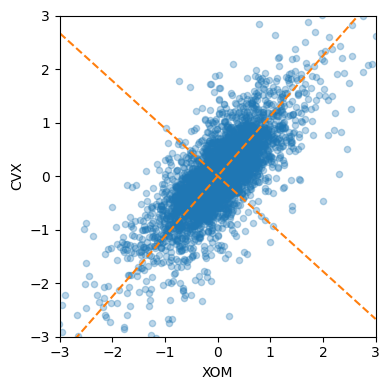

In [5]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

- 첫 번째 선은 타인의 장축을 따라 존재하며 두 번째 선은 단축 위에 존재함
- 두 주가 수익에서 대부분의 변동성은 첫 번째 주성분을 통해 설명 가능
- 석유 관련 주가가 한 그룹으로 움직이는 경향이 있다고 함

### B. 주성분 계산
---
- 변수 세 개 이상일 때로 확장 = 첫 성분의 선형결합 수식에 단순히 독립변수 추가
- 독립변수들의 첫 주성분에 대한 **공변동(covariation)** 집합이 최적화되도록 가중치 할당
- 전체 과정
    1. 첫 번째 주성분을 구하기 위해, 전체 변동을 최대한 설명하기 위한 독립변수의 선형 결합 계산
    1. 이 선형 결합은 첫 번째 새로운 예측변수 $Z_1$이 됨
    1. 같은 변수들을 이용해 새로운 두 번째 변수 $Z_2$를 만들기 위해, 다른 가중치를 가지고 반복 (가중치는 $Z_1$과 $Z_2$가 서로 상관성이 없도록 결정)
    1. 원래 변수 $X_i$의 개수만큼 새로운 변수 $Z_i$를 구할 때까지 과정 계속
    1. 대부분의 변동을 설명하기 위해 필요한 만큼의 주성분을 선택해 남겨놓음
    1. 각 주성분에 대한 가중치 집합을 얻게 되는데, 이를 적용해 원레 데이터를 새로운 주성분으로 변형

### C. 주성분 해석
---
- 주성분의 표준화된 두 가지 시각화 방법
    - 스크리그래프: 주성분의 상대적인 중요도 표시
        - y축은 고윳값 의미
    - 상위 주성분들의 가중치 표시 그래프

#### 스크리그래프

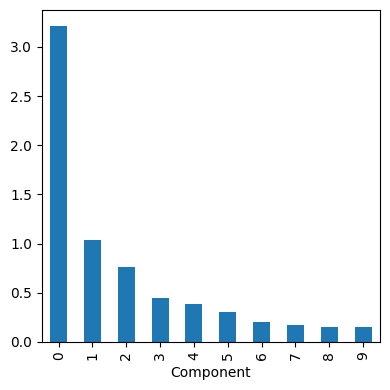

In [6]:
# sklearn의 explain_variances_
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

#### 가중치 표시 그래프

In [7]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :],
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0  0.300825  0.246332  0.261529  0.273634  0.064059  0.444490  0.207983   
1  0.505116  0.139426 -0.174212  0.416307  0.031939 -0.289373  0.278002   
2  0.786730 -0.135458  0.002367 -0.465862  0.007524 -0.082374 -0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4 -0.111576  0.596666  0.005813 -0.555529  0.039860 -0.109016  0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0  0.076956  0.196397  0.105012  0.481786  0.148833  0.116421  0.145684   
1  0.033898  0.040723  0.053954 -0.472494  0.228123  0.054796  0.047427   
2  0.003518 -0.062261 -0.016248  0.194822 -0.160833 -0.048976 -0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4  0.072047  0.385160  0.077135 -0.181332  0.055557  0.155440  0.216425   

        WMT       XOM  
0  0.122304  0.317952  
1  0.222889 -0.154192  
2 -0.175806 -0.090167  
3 

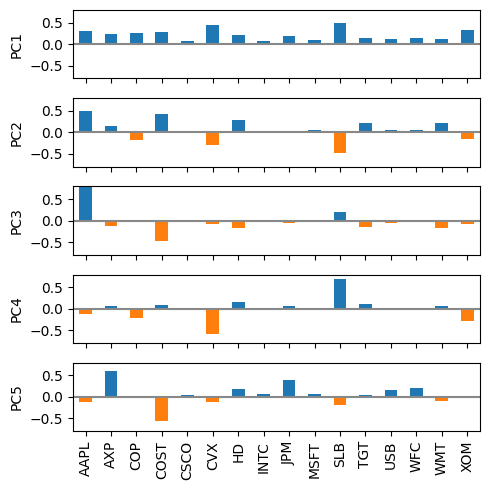

In [8]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

### D. 대응분석(Correspondence Analysis)
---
- PCA는 범주형 데이터에 사용할 수 없으나 그래도 어느 정도 관련 있는 기술은 대응분석임
- 범주 간 혹은 범주형 피처 간의 연관성을 인식하는 것이 목적
- 주로 저차원 범주형 데이터의 그래프 분석에 이용됨
- 빅데이터 준비 단계에서 차원 축소를 위해 PCA를 사용하는 것과는 다른 방식으로 사용됨
- input = 각 변수를 의미하는 행과 열, 그리고 레코드 수를 나타내는 셀로 이뤄진 테이블
- output = 스케일이 조정된 산점도인 바이플롯(biplot)

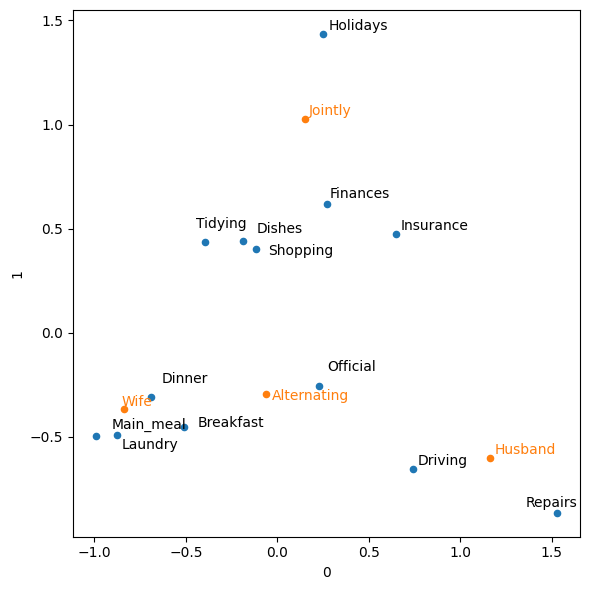

In [9]:
from adjustText import adjust_text

housetasks = pd.read_csv('../data/housetasks.csv', index_col=0)

# sklearn API를 사용하여 대응분석을 구현한 prince 패키지 사용
ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'})
plt.tight_layout()
plt.show()

- 세로축 = 부부가 집안일을 함께 하는지 아니면 혼자 하는지를 나타냄 (Jointly vs Alternating)
- 가로축 = 각 집안일의 담당이 아내인지 남편인지 표시 (Wife vs Husband)

## 2. k-평균 클러스터링
---
- **군집(cluster)**: 서로 유사한 레코드들의 집합
- **클러스터 평균(cluster mean)**: 한 클러스터 안에 속한 레코드들의 평균 벡터 변수
- **k**: 클러스터의 개수

```
k-평균에서는 할당된 클러스터의 평균과 포함된 데이터들의 거리 제곱합(클러스터 내 제곱합 또는 클러스터 내 SS)이 최소가 되도록 한다.
k-평균은 각 클러스터의 크기가 동일하다는 보장은 없지만 클러스터들끼리는 최대한 멀리 떨어지도록 한다.
```

### A. 간단한 예제
---
- 변수가 $x$, $y$ 두 개이고 레코드가 $n$개인 데이터 & $k=4$ 가정
    - 각 레코드 $(x_i, y_i)$를 클러스터 $k$에 할당
    - 클러스터 $k$에 $n_k$개의 레코드가 들어 있다고 할 때, 클러스터의 중심 $(\bar{x_k}, \bar{y_k})$는 클러스터 내에 존재하는 점들의 평균 의미
        - $\bar{x_k}={1 \over n}\sum_{i∈클러스터 k}x_i$
        - $\bar{y_k}={1 \over n}\sum_{i∈클러스터 k}y_i$
    - 클러스터 내부의 제곱합
        - $SS_k=\sum_{i∈클러스터 k}(x_i-\bar{x_k})^2+(y_i-\bar{y_k})^2$
    - 4개의 모든 클러스터의 내부 제곱합이 최소가 되도록 레코드들을 클러스터에 할당
        - $sum_{k=1}^4 SS_k$

```
※ 클러스터 평균

여러 변수가 존재하는 레코드들을 클러스터링할 때,
클러스터 평균이라는 것은 하나의 값(스칼라)이 아닌 각 변수들의 평균으로 이루어진 벡터를 의미한다.
```

In [10]:
# 일별 주가수익률을 네 그룹으로 나누고자 함
# 주식 수익률은 이미 표준화된 방식으로 보고되므로 데이터를 따로 정규화할 필요 없음

# sklearn.cluster의 KMeans 메서드 사용
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4, n_init='auto').fit(df)
df['cluster'] = kmeans.labels_ #클러스터 라벨
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        3
2011-01-04  0.168668 -0.584516        2
2011-01-05  0.026631  0.446985        3
2011-01-06  0.248558 -0.919751        2
2011-01-07  0.337329  0.180511        3


In [11]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX']) #클러스터 중심
print(centers)

        XOM       CVX
0  1.092072  1.581077
1 -1.123045 -1.718845
2 -0.286422 -0.492965
3  0.325846  0.449970


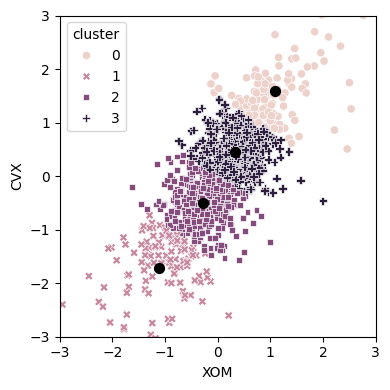

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster',
                     ax=ax, data=df) #속성별 점의 색상과 스타일 할당
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

### B. k-평균 알고리즘
---
- 정확한 해를 계산하기는 매우 어려우므로, 휴리스틱한 방법을 통해 국소최적화된 해를 효과적으로 계산
- 과정
    1. 사용자가 미리 정해준 k 값과 클러스터 평균의 초깃값을 가지고 시작한다.
    1. 각 레코드를 거리가 가장 가까운 평균을 갖는 클러스터에 할당한다.
    1. 새로 할당된 레코드들을 가지고 새로운 클러스터 평균을 계산한다.
    1. 각 레코드에 대한 클러스터 할당이 더는 변화하지 않을 때(알고리즘이 수렴했다고 볼 수 있을 때)까지 반복한다.
- 클러스터 평균의 초깃값을 랜덤하게 변화시켜가며 알고리즘을 여러 번 돌려봐야 함

In [13]:
# n_init: 기본적으로 10번 반복
# max_iter: 반복 횟수 제어(기본값 300)
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5, n_init='auto').fit(top_sp)

### C. 클러스터 해석
---
- 가장 중요한 두 output
    - 클러스터 크기
    - 클러스터 평균

In [14]:
# 클러스터의  크기
# 표준 라이브러리 collections의 Counter 클래스 사용
from collections import Counter
print(Counter(kmeans.labels_))

Counter({1: 303, 3: 284, 0: 274, 2: 159, 4: 111})


- 클러스터 크기가 비교적 균일함

```
유난히 균형이 맞지 않는 클러스터가 존재한다면,
이는 아주 멀리 떨어진 특이점들이 있거나 아니면
어떤 레코드 그룹이 나머지 데이터로부터 아주 멀리 떨어져 있다는 것을 의미한다.
따라서 이런 경우 좀 더 자세히 들여다볼 필요가 있다.
```

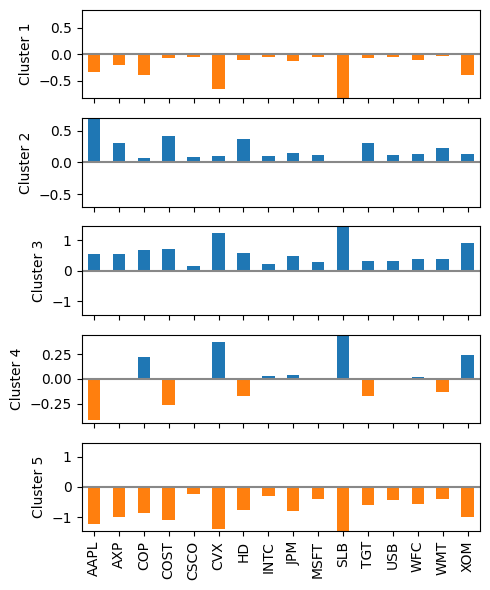

In [15]:
# 클러스터의 중심(평균)
# PCA의 경우와 유사함
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

- 클러스터 2와 4 = 각각 주식시장이 내리고 오른 날
- 클러스터 1과 3 = 각각 에너지 관련 주식이 내린 날과 소비재 주식이 오른 날
- 클러스터 5 = 에너지 주식은 오르고 소비재 주식은 내린 날

### D. 클러스터 개수 선정
---
- 클러스터 개수를 미리 결정할 수 있는 경우도 있지만 미리 결정하기 어려울 수도 있음
- 클러스터 개수를 결정하기 위해 통계적 접근 방식을 사용할 수 있음
- '최상의' 클러스터 개수를 찾는 딱 한 가지 표준화된 방법은 없음
- 팔꿈치 방법(elbow method): 언제 클러스터 세트가 데이터 분산의 '대부분'을 설명하는지를 알려줌
    - '대부분'을 설명하는 때에 새로운 클러스터를 더 추가하면 분산에 대한 기여도가 상대적으로 작아짐
    - 누적 분산이 가파르게 상승한 다음 어느 순간 평평하게 되는 지점
    - 눈에 띄는 지점이 없을 수 있지만 데이터의 특성을 밝혀준다는 의의
    

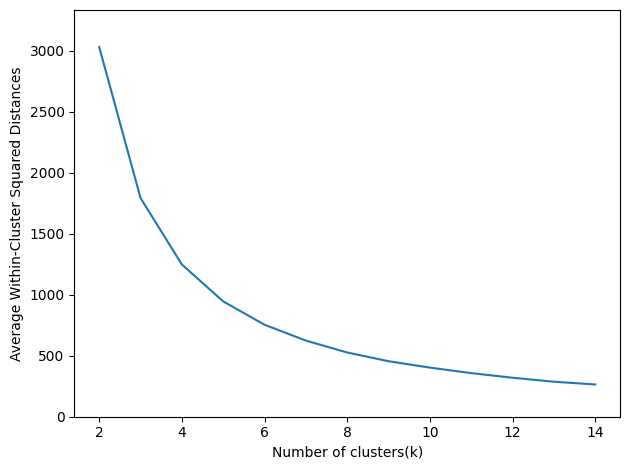

In [16]:
# KMeans의 속성 inertia_
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

- 유지할 클러스터 개수 평가
    - 클러스터들이 새로운 데이터에서도 그대로 유지될 가능성이 얼마나 있을까?
    - 클러스터는 해석 가능한가?
    - 데이터의 일반적인 특성과 관련이 있는가? 아니면 특정 데이터만 반영하는가?
- *교차타당성검사*를 사용하면 이러한 것들을 부분적으로 평가할 수 있음

## 3. 계층적 클러스터링(hierarchical clustering)
---
- **덴드로그램(dendrogram)**: 레코드들, 그리고 레코드들이 속한 계층적 클러스터를 시각적으로 표현
- **거리(distance)**: 한 *레코드*가 다른 레코드들과 얼마나 가까운지를 보여주는 측정 지표
- **비유사도(dissimilarity)**: 한 *클러스터*가 다른 클러스터들과 얼마나 가까운지를 보여주는 측정 지표

- k-평균 대신 사용하는 클러스터링 방법
- 서로 다른 수의 클러스터를 지정하는 효과 시각화 (클러스터의 수를 미리 지정할 필요 없음)
- 특이점이난 비정상적인 그룹이나 레코드를 발견하는 데 더 민감함
- 직관적인 시각화가 가능하여 클러스터를 해석하기가 수월함
- 유연성에는 비용이 따르므로 대규모 데이터에는 적용할 수 없음
- 적당한 크기의 데이터의 경우에도 상대적을 많은 컴퓨팅 리소스가 필요할 수 있음
- 대부분 상대적으로 데이터 크기가 작은 문제에 주로 적용

### A. 간단한 예제
---
- $n$개의 레코드와 $p$개의 변수가 있는 일반적인 데이터
- 두 가지 기본 구성 요소
    - 두 개의 레코드 $i$와 $j$ 사이의 거리를 측정하기 위한 거리 측정 지표
    - 두 개의 클러스터 $A$와 $B$ 사이의 차이를 측정하기 위한, 각 클러스터 구성원 간의 거리 $d_{i,j}$를 기반으로 한 비유사도 측정 지표 $D_{A,B}$

In [17]:
# scipy 패키지의 scipy.cluster.hierarchy 모듈
# 메서드를 'complete'로 지정하여 linkage 함수 사용
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD',
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


```
클러스터링 알고리즘은 데이터 프레임의 행들을 클러스터링한다.
이에 맞게 필요하다면 데이터 프레임을 전치(transpose)할 수 있다.
```

### B. 덴드로그램
---
- 계층적 클러스터링은 트리 모델과 같이 자연스러운 시각적 표현이 가능하며, 이를 덴드로그램이라고 함

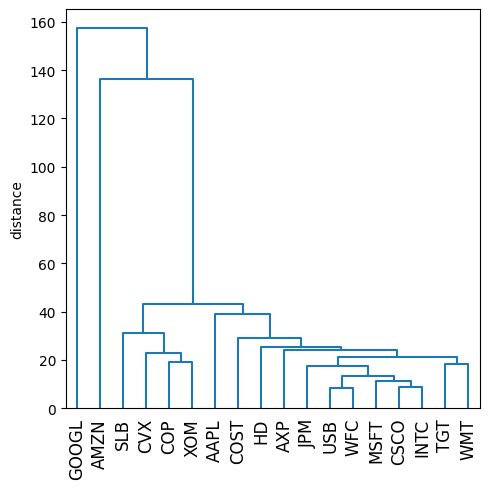

In [18]:
# linkage 함수의 결과를 시각화하기 위해 dendrogram 메서드 사용
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

- 트리의 잎 = 각 레코드
- 트리의 가지 길이 = 해당 클러스터 간의 차이 정도

In [19]:
# fcluster 메서드를 사용하여 원하는 개수의 클러스터 추출
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


### C. 병합(agglomerative) 알고리즘
---
- 유사한 클러스터들을 반복적으로 병합하는 역할
- 단일 레코드로 구성된 클러스터에서 시작하여 점점 더 큰 클러스터 생성
- 주요 단계
    1. 데이터의 모든 레코드에 대해, 단일 레코드로만 구성된 클러스터들로 초기 클러스터 집합 생성
    1. 모든 쌍의 클러스터 $k, l$ 사이의 비유사도 $D(C_k, C_l)$ 계산
    1. 에 따라 가장 가까운 두 클러스터 $C_k$와 $C_l$ 병합
    1. 클러스터가 하나 남을 때까지 2단계부터 반복

### D. 비유사도 측정
- 네 가지 일반적인 지표
    - 완전연결(complete linkage): 모든 레코드 쌍의 최대 거리 사용
    - 단일연결(single linkage): 두 클러스터의 레코드 간 최소 거리 사용
        - 탐욕적인(greedy) 방법
    - 평균연결(average linkage): 모든 거리 쌍의 평균 사용
        - 단일연결과 완전연결 절충
    - 최소분산(minimum variance): 클러스터 내의 제곱합 최소화
        - = 워드 기법(Ward's method)

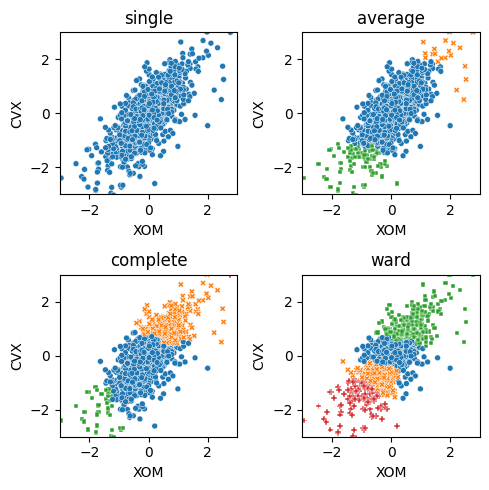

In [20]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

## 4. 모델 기반 클러스터링
---
- 계층적 클러스터링과 k-평균 같은 클러스터링 방법들은 모두 휴리스틱한 방법(heuristic)이라고 할 수 있음
- 모델 기반 클러스터링은 통계 이론에 기초하고 있으며 클러스터의 성질과 수를 결정하는 더 엄격한 방법을 제공함
- 핵심 아이디어 = 각 레코드가 k개의 다변량정규분포 중 하나로부터 발생했다고 가정하는 것
    - k가 클러스터의 개수 의미

### A. 다변량정규분포(multivariate normal distribution)
---
- $p$개의 변수 집합 $X_1,X_2,\cdots,X_p$에 대해 정규분포를 일반화한 것
- 분포는 평균 집합 $\mu=\mu_1,\mu_2,\cdots,\mu_p$와 공분산 행렬 $\Sigma$로 정의

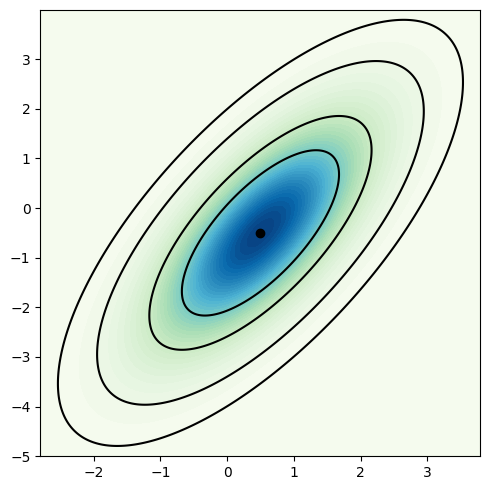

In [21]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

- 다변량정규분포의 확률 등고선

### B. 정규혼합

In [22]:
# sklearn.mixture.GaussianMixture 클래스
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4589.92885731864


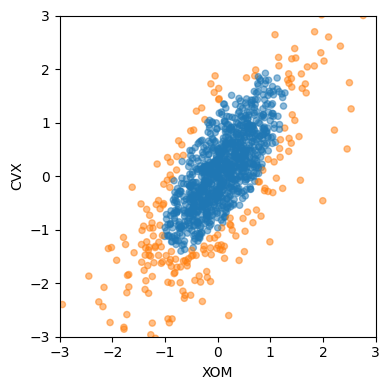

In [23]:
# 클러스터 시각화
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [24]:
# 각 정규분포의 파라미터 추출
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[ 0.07246995  0.10494619]
 [-0.05031426 -0.21161823]]
Covariances
[[[0.26822676 0.27562091]
  [0.27562091 0.51679853]]

 [[0.97123064 0.97764343]
  [0.97764343 1.67233845]]]


### C. 클러스터 개수 결정
---
- R의 `mclust`와 달리 파이썬의 `GaussianMixture`에서는 다양한 조합을 시도하지 않음
- 베이즈 정보기준(BIC)를 최소화

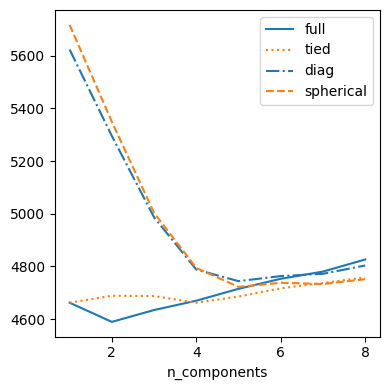

In [25]:
# warm_stat 인수를 사용하여 이전 피팅 정보 재사용 -> 후속 계산의 수렴 속도가 빨라짐
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })

results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type,
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

## 5. 스케일링과 범주형 변수

### A. 변수 스케일링

### B. 지배 변수

### C. 범주형 데이터와 고워 거리

### D. 혼합 데이터의 클러스터링 문제